In [19]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np

In [4]:
__file__ = 'C:/Users/antie/Documents/Pole_recherche/Tsunami'

In [2]:
__file__ = 'C:/Users/Gilles/CS/cours/PoleProjet/FormationRecherche/Tsunami/TP/sceance4/Tsunami'

In [4]:
import os

print(os.getcwd())
os.chdir(__file__)
print(os.getcwd())

C:\Users\Gilles\CS\cours\PoleProjet\FormationRecherche\Tsunami\TP\sceance4\Tsunami
C:\Users\Gilles\CS\cours\PoleProjet\FormationRecherche\Tsunami\TP\sceance4\Tsunami


In [5]:
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

## Create the model

In [85]:
# To fix weights or biases of layers
class ConstantTensorInitializer(tf.keras.initializers.Initializer):
  """Initializes tensors to `t`."""

  def __init__(self, t):
    self.t = t

  def __call__(self, shape, dtype=None):
    return self.t

  def get_config(self):
    # A constraint config is a Python dictionary (JSON-serializable) that can be used to reinstantiate the same object.
    return {'t': self.t}

class ConstantTensorConstraint(tf.keras.constraints.Constraint):
  """Constrains tensors to `t`."""

  def __init__(self, t):
    self.t = t

  def __call__(self, w):
    return self.t

  def get_config(self):
    return {'t': self.t}


# t could be :
t = tf.ones((3,4))
print(t)

t1 = tf.eye(3,4)
print(t1)

tf.Tensor(
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]], shape=(3, 4), dtype=float32)


In [86]:
def generate_model():
  # méthode API Sequential
  multilayer_perceptron = keras.models.Sequential([
    keras.layers.Input(shape=(2)),
    #keras.layers.GaussianNoise(stddev=1e-3),
    keras.layers.Dense(20,activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(20,activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(1,use_bias=False)
  ])
  multilayer_perceptron.summary()
  return multilayer_perceptron


In [76]:
# to check :
multilayer_perceptron = generate_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 20)                60        
                                                                 
 dense_10 (Dense)            (None, 20)                420       
                                                                 
 dense_11 (Dense)            (None, 1)                 20        
                                                                 
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________


In [75]:
print('len(multilayer_perceptron.trainable_variables):',len(multilayer_perceptron.trainable_variables))

len(multilayer_perceptron.trainable_variables): 5


In [12]:
import Polynomials.polynome4students_v2 as Pstud

frontier_coords = Pstud._set_coords_rectangle(1,1,40)

F_xpy_real = Pstud._set_polynome_xpy_numpy_real(frontier_coords)
F_expxpy_real = Pstud._set_polynome_expxpy_numpy_real(frontier_coords)
F_sinxpy_real = Pstud._set_polynome_sinxpy_numpy_real(frontier_coords)

F_xpy_cmplx = Pstud._set_polynome_xpy_numpy_cmplx(frontier_coords)

F facile :

In [ ]:
import sympy as sm
x,y = sm.symbols('x,y')

def expr_dummy_F():
    return x*(1-x)*y*(1-y)

expr_dummy_F = x*(1-x)*y*(1-y)
dexpr_dummy_F_dx = ...


In [87]:
# Given EDO
def f(X):
  return tf.sin(np.pi*X[:,0])*tf.sin(np.pi*X[:,1])


def boundary_conditions(X):
  return 0


def residual(du_dxx,du_dyy,f_ind):
  return du_dxx+du_dyy+f_ind


def differentiate(model,x):
  with tf.GradientTape(persistent=True) as tape:
    x1, x2 = x[:,0:1], x[:,1:2]
    tape.watch(x1)
    tape.watch(x2)
    u = model(tf.stack([x1[:,0], x2[:,0]], axis=1))
    du_dx = tape.gradient(u,x1)
    du_dy = tape.gradient(u,x2)
  du_dxx = tape.gradient(du_dx,x1) 
  du_dyy = tape.gradient(du_dy,x2)
  return du_dxx,du_dyy


grid_length = 100


X = np.linspace(0,1,grid_length, endpoint=True)
Y = np.linspace(0,1,grid_length, endpoint=True)
tf_coords = tf.convert_to_tensor([tf.constant([x,y],dtype=DTYPE) for x in X for y in Y])
tf_boundary_coords = tf.convert_to_tensor([tf.constant([x,y],dtype=DTYPE) for x in [0,1] for y in Y ] + [tf.constant([x,y],dtype=DTYPE) for y in [0,1] for x in X ])  

#print(boundary_coords.shape)



## Method 1: mini-batch gradient descent with training to respect the boundary conditions at the same time of the one for the EDP

In [88]:
# method 1: mini-batch gradient descent + (loss = MSE + MSE on all boundary) 

# a few train parameters to adjust
learning_rate = 0.01
training_steps = 200
batch_size = 1000
display_step = 100

alpha = 15 # magnify the boundary condition in the loss

optimizer = tf.optimizers.Adam(lr=learning_rate)

# generate model
multilayer_perceptron = generate_model()


# Universal Approximator
def g(x):
  # F_x = Pstud._eval_polynome_numpy(F_xpy_real,x[0,0],x[0,1])
  N_x = multilayer_perceptron(x)
  return N_x


# Custom loss function to approximate the derivatives

def custom_loss_1():
  indices = np.random.randint(tf_coords.shape[0],size=batch_size)
  tf_sample_coords = tf.convert_to_tensor([tf_coords[i] for i in indices])

  dg_dxx,dg_dyy = differentiate(g,tf_sample_coords)
  f_r = tf.reshape(f(tf_sample_coords),[batch_size,1])
  res = residual(dg_dxx,dg_dyy,f_r)

  loss = tf.reduce_mean(tf.square(res)) + alpha*tf.reduce_mean(tf.square(g(tf_boundary_coords)-boundary_conditions(tf_boundary_coords)))
  return loss

# train of method 1: 
def train_step_1():
  with tf.GradientTape() as tape:
    loss = custom_loss_1()
  trainable_variables=multilayer_perceptron.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 20)                60        
                                                                 
 dense_25 (Dense)            (None, 20)                420       
                                                                 
 dense_26 (Dense)            (None, 1)                 20        
                                                                 
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________


C:\Users\Gilles\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [89]:
# Training the Model of method 1:

all_losses = []

for i in range(training_steps):
  print('epoch:',i)
  train_step_1()
  loss = custom_loss_1()
  if i % display_step == display_step-1:
    print("loss:", loss)
  all_losses.append(loss)

plt.plot(np.arange(0,training_steps),all_losses)
plt.show()

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92
epoch: 93
epoch: 94
epoch: 95
epoch: 96
epoch: 97
epoch: 98
epoch: 99
loss: tf.T

KeyboardInterrupt: 

## Method 2: MBGD with pretraining to respect the boundary condition

In [81]:
# method 2 : pretrain before on the boundary condition and after inside the boundary

# a few train parameters to adjust
learning_rate = 0.01
training_steps_boundary = 200
training_steps_global = 100
batch_size = 1000
display_step_boundary = 10
display_step_global = 10

alpha=0 # magnify the boundary condition in custom_loss_inside()

optimizer = tf.optimizers.Adam(lr=learning_rate)

# generate model
multilayer_perceptron = generate_model()

# Custom loss function to approximate the derivatives
def custom_loss_2_boundary():
  indices = np.random.randint(tf_boundary_coords.shape[0],size=batch_size)
  tf_sample_boundary_coords = tf.convert_to_tensor([tf_boundary_coords[i] for i in indices])

  loss = tf.reduce_mean(tf.square(g(tf_sample_boundary_coords)-boundary_conditions(tf_sample_boundary_coords)))
  # print('loss :', loss)
  return loss


def custom_loss_2():
  indices = np.random.randint(tf_coords.shape[0],size=batch_size)
  tf_sample_coords = tf.convert_to_tensor([tf_coords[i] for i in indices])

  dg_dxx,dg_dyy = differentiate(g,tf_sample_coords)
  f_r = tf.reshape(f(tf_sample_coords),[batch_size,1])
  res = residual(dg_dxx,dg_dyy,f_r)

  loss = tf.reduce_mean(tf.square(res)) + alpha*tf.reduce_mean(tf.square(g(tf_boundary_coords)-boundary_conditions(tf_boundary_coords)))
  return loss


# train of method 2:
def train_step_2_boundary():
  with tf.GradientTape() as tape:
    loss = custom_loss_2_boundary()
  trainable_variables=multilayer_perceptron.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

def train_step_2_inside():
  with tf.GradientTape() as tape:
    loss = custom_loss_2()
  trainable_variables=multilayer_perceptron.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 20)                60        
                                                                 
 dense_19 (Dense)            (None, 20)                420       
                                                                 
 dense_20 (Dense)            (None, 1)                 20        
                                                                 
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the Model of method 2:

all_losses = []
bound_losses = []
b_global_losses=[]
global_losses = []
for i in range(training_steps_boundary):
  print('epoch:',i)
  train_step_2_boundary()
  loss = custom_loss_2_boundary()
  if i % display_step_boundary == display_step_boundary-1:
    print("loss boundary: ", loss)
  bound_losses.append(loss)
  b_global_losses.append(custom_loss_2())

for i in range(training_steps_global):
  print('epoch:',i)
  train_step_2_inside()
  loss = custom_loss_2()
  if i % display_step_global == display_step_global-1:
        print("loss :", loss)
  global_losses.append(loss)



plt.figure(1, figsize=(15, 5))

plt.subplot(211)
plt.plot(np.arange(0,training_steps_boundary),bound_losses, color='blue', label='loss on the boundary')
plt.plot(np.arange(0,training_steps_boundary), b_global_losses, color='black', label='global loss during training on boundary')

plt.subplot(212)
plt.plot(np.arange(0,training_steps_global), global_losses, color='red', label='global loss during global training')

plt.show() 


In [ ]:
def damp(t):
    return np.exp(-t) * np.cos(2*np.pi*t)


x1 = np.arange(0.0, 5.0, 0.1)
x2 = np.arange(0.0, 5.0, 0.02)
y2 = np.cos(2*np.pi*x2)


plt.figure(1, figsize=(15, 5))

plt.subplot(211)
plt.plot(x1, damp(x1), color='blue', marker='o', label='data')
plt.plot(x2, damp(x2), color='black', label='datapoints')

plt.subplot(212)
plt.plot(x2, y2, color='red', linestyle='--', label='signal')

plt.show()  # doctest: +SKIP

Remark for method 1: considering the low evolution after 100 epochs, we could have end it.

## Compare to the true solution

In [12]:
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

In [13]:
def true_function(X):
    return tf.sin(np.pi*X[:,0])*tf.sin(np.pi*X[:,1])/(2*np.pi**2)

def false_appro_function(X):
    return tf.sin(np.pi*X[:,0])*tf.sin(np.pi*X[:,1])/(np.pi**2)+1

In [67]:
# print(tf.reshape(tf_coords,[100,100,2]))
# print(tf.reshape(tf_coords,[100,100,2])[-1])

# to check that the model is not overfitting
# Rk: may blur the cmapping then
noise = (tf.random.uniform((grid_length**2,2))-0.5)/grid_length

tf_noisy_coords = tf_coords+noise

true_values = tf.reshape(true_function(tf_noisy_coords),[100,100]).numpy()
appro_values = tf.reshape(g(tf_noisy_coords),[100,100]).numpy()
error = np.abs(true_values-appro_values)

print(np.max(error))
print(error.shape)

0.9950819
(100, 100)


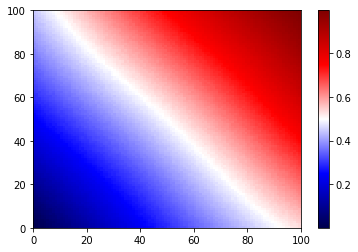

In [68]:
seismic = cm.get_cmap('seismic', 1024)
# visualize with the new_inferno colormaps
plt.pcolormesh(error, cmap = seismic)
plt.colorbar()


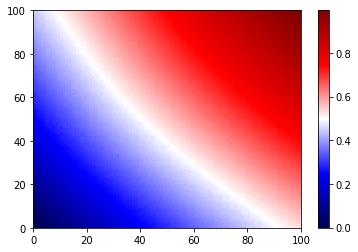

In [69]:
plt.pcolormesh(appro_values, cmap = seismic)
plt.colorbar()

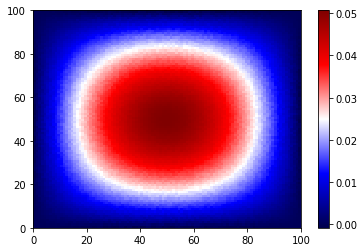

In [70]:
plt.pcolormesh(true_values, cmap = seismic)
plt.colorbar()

Les valeurs sont très petites aux bords. L'écart avec les conditions aux frontières doit être négligé. 

## Save the model

In [21]:
multilayer_perceptron.save('differentiate/model_EDP_2D.h5')

## Load the model

In [18]:
multilayer_perceptron = keras.models.load_model('differentiate/model_EDP_2D.h5')

# Questions 

Quelle architecture ? 

Comment éviter l'overfitting ?

Comment exploiter les avantages de l'IA ?

Choix de l'optimizer + regularizer ? + Implémentation ?

Implémentation de système d'EDP à plusieurs inconnues (étant des fonctions bien sûr) ? (Est-ce que c'est utile ça ? Par curiosité)

Plus rapide ? Comment enlever les boucles `for` ? => mini_batch_gradient_descent ? done

Besoin de batch_normalization ? + autres hyperparamètres ?

# Idées

Ajout de bruit en entrée contre l'overfitting 

Une sortie par inconnue